In [1]:
from ema_workbench import (Model, RealParameter,CategoricalParameter, IntegerParameter, TimeSeriesOutcome, ema_logging, perform_experiments)
# from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.em_framework.evaluators import MultiprocessingEvaluator
from ema_workbench.em_framework.outcomes import ArrayOutcome, ScalarOutcome
from ema_workbench.util import ema_exceptions
#from ema_workbench.analysis.plotting import lines
from ema_workbench.analysis import pairs_plotting
#feature scoring
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis import prim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from pandas.core.indexing import convert_missing_indexer, convert_to_index_sliceable
import os 
import warnings
from math import floor
from ema_workbench.analysis import dimensional_stacking
from scipy import stats

# Change the current working directory
os.chdir('C:\\Users\\wb558960\\OneDrive - WBG\\CCDRs LAC\\Argentina\\DeepDives\\Vaca Muerta\\Python\\src')
#print("Current working directory: {0}".format(os.getcwd()))

In [2]:
indir = "C:\\Users\\wb558960\\OneDrive - WBG\\CCDRs LAC\\Argentina\\DeepDives\\Vaca Muerta\\Python\\outputs_rdm\\outputs_v3\\n_10000\\"
outdir ='C:\\Users\\wb558960\\OneDrive - WBG\\CCDRs LAC\\Argentina\\DeepDives\\Vaca Muerta\\Python\\outputs\\'

In [3]:
colnames= ['year','run','Conv_gas_price','Unconv_gas_price','Conv_oil_price','Unconv_oil_price',
'Conv_gas_ds_capex','Unconv_gas_ds_capex','Conv_oil_ds_capex','Unconv_oil_ds_capex',
'Conv_gas_opex','Unconv_gas_opex','Conv_oil_opex','Unconv_oil_opex',
'Conv_gas_domestic revenue','Unconv_gas_domestic revenue','Conv_oil_domestic revenue','Unconv_oil_domestic revenue',
'Conv_gas_export revenue','Unconv_gas_export revenue','Conv_oil_export revenue','Unconv_oil_export revenue',
'Conv_gas_production subsidy','Unconv_gas_production subsidy','Conv_oil_production subsidy','Unconv_oil_production subsidy',
'Conv_gas_import subsidy','Unconv_gas_import subsidy','Conv_oil_import subsidy','Unconv_oil_import subsidy',
'Conv_gas_royalties','Unconv_gas_royalties','Conv_oil_royalties','Unconv_oil_royalties',
'Conv_gas_export duties','Unconv_gas_export duties','Conv_oil_export duties','Unconv_oil_export duties',
'Conv_gas_trade balance','Unconv_gas_trade balance','Conv_oil_trade balance','Unconv_oil_trade balance',
'Conv_gas_us_capex','Unconv_gas_us_capex','Conv_oil_us_capex','Unconv_oil_us_capex',
'Conv_gas_starts','Unconv_gas_starts','Conv_oil_starts','Unconv_oil_starts',
'Conv_gas_discount_factor','Unconv_gas_discount_factor','Conv_oil_discount_factor','Unconv_oil_discount_factor']


In [4]:
outcomes = pd.read_csv(indir+"vm_outcomes_2.csv")
experiments = pd.read_csv(indir+"vm_experiments_2.csv")
tradebal= pd.read_csv(indir+"fiscal ts outcomes_2.csv",index_col = False,names = colnames, skiprows = 1 )
physbal = pd.read_csv(indir+"physical ts outcomes_2.csv" )

In [5]:
fbal = tradebal.groupby('run').sum()
fbal=fbal/643629000000*100

# pbal =  physbal.groupby('run').mean()
# print(pbal.head())

In [6]:
data = pd.merge(outcomes, experiments)
data = data.rename(columns= {'Unnamed: 0':'run'}).set_index('run')
data = pd.merge(data,fbal, left_on = 'run',right_on= 'run')

In [7]:
data.columns

Index(['npv_gdp', 'npv_unsub_gdp', 'total_ft_gdp', 'wells_total',
       'unconv_share', 'gas_share', 'gdp_npv_conv_gas', 'gdp_npv_conv_oil',
       'gdp_npv_unconv_gas', 'gdp_npv_unconv_oil',
       ...
       'Conv_oil_us_capex', 'Unconv_oil_us_capex', 'Conv_gas_starts',
       'Unconv_gas_starts', 'Conv_oil_starts', 'Unconv_oil_starts',
       'Conv_gas_discount_factor', 'Unconv_gas_discount_factor',
       'Conv_oil_discount_factor', 'Unconv_oil_discount_factor'],
      dtype='object', length=127)

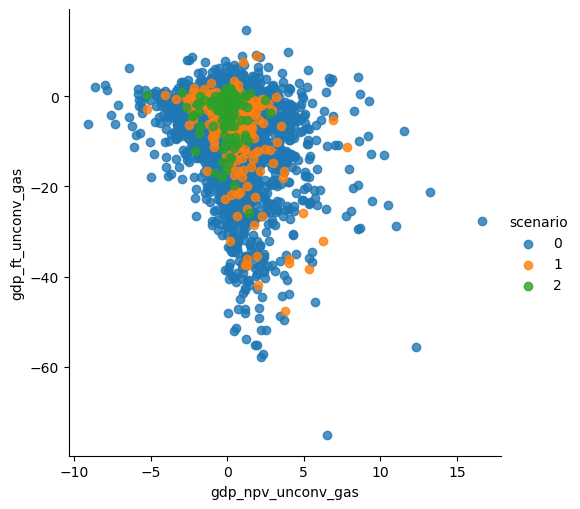

In [8]:
#define scenario
#&(data['t_rate_gas'] > .003)&

data.scenario = 0 
data.loc[(data['rcp'] =='CURR')&(data['gas_export_dem_end'] > .1)&(data['wells_total'] >=15000), 'scenario'] =0
data.loc[(data['rcp'] =='1.5')&(data['gas_export_dem_end'] <=.1)&(data['wells_total'] >=15000), 'scenario'] =1
data.loc[(data['rcp'] =='1.5')&(data['gas_export_dem_end'] <=.1) &(data['wells_total'] <15000), 'scenario'] = 2

plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='scenario', legend=True)
plt.show()

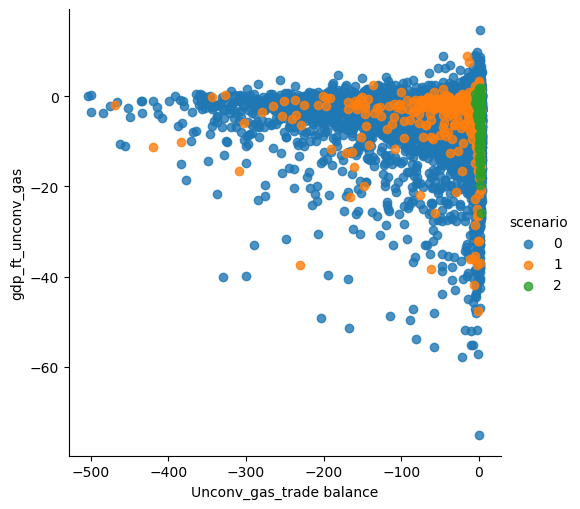

In [9]:

plot = sns.lmplot(x="Unconv_gas_trade balance", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='scenario', legend=True)
plt.show()

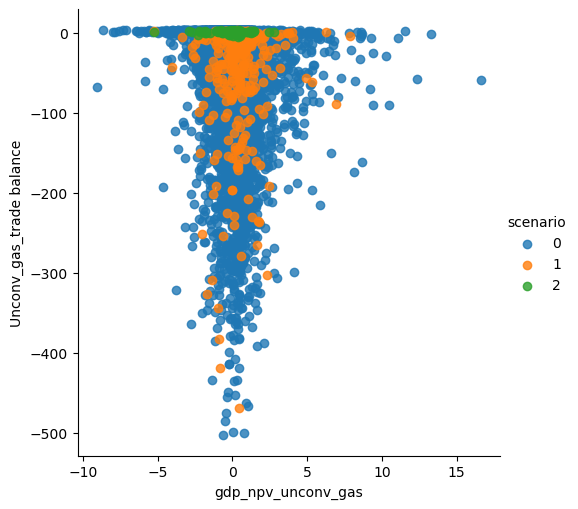

In [10]:
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="Unconv_gas_trade balance", data=data, fit_reg=False, hue='scenario', legend=True)
plt.show()

In [11]:
#define success

data.loc[(data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0)&(data['Unconv_gas_trade balance'] >0), 'success3'] ="Positive Impacts"
data.loc[(data['gdp_npv_unconv_gas'] <0)|(data['gdp_ft_unconv_gas'] <0)|(data['Unconv_gas_trade balance'] <0), 'success3'] ="Negative Impacts"

data.loc[(data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0), 'success_ft'] =1
data.loc[(data['gdp_npv_unconv_gas'] <0)|(data['gdp_ft_unconv_gas'] <0), 'success_ft'] =0

data.loc[(data['Unconv_gas_trade balance'] >0)&(data['gdp_npv_unconv_gas'] >0), 'success_tb'] =1
data.loc[(data['Unconv_gas_trade balance'] <0)|(data['gdp_npv_unconv_gas'] <0), 'success_tb'] =0

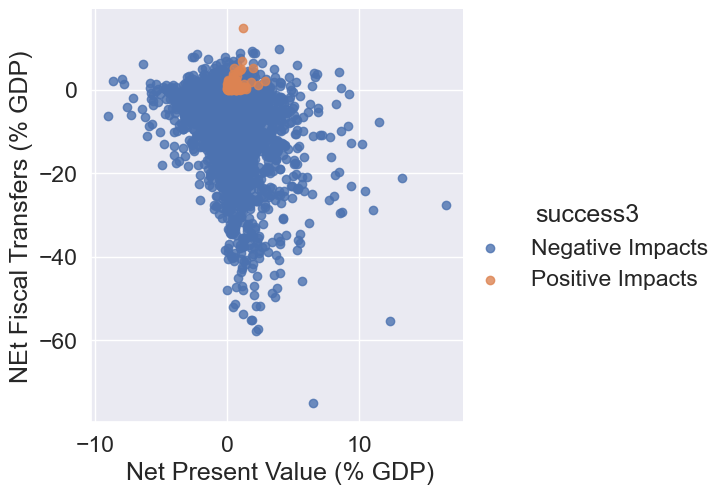

In [12]:
#add legend and axis labels here
sns.set(font_scale = 1.5)
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='success3', legend=True)
plot.set_titles("Impacts of Vaca Muerta")  # use this argument literally
plot.set_axis_labels(x_var=" Net Present Value (% GDP)", y_var="NEt Fiscal Transfers (% GDP)")

plt.show()

In [13]:
pd.crosstab(data['scenario'],data['success_tb'])


success_tb,0.0,1.0
scenario,,
0,8194,1299
1,367,29
2,68,43


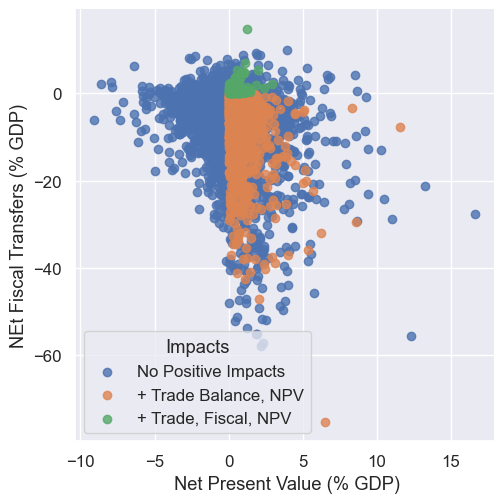

In [14]:
#graph for executive Summary

data.loc[(data['gdp_npv_unconv_gas'] <0)|(data['gdp_ft_unconv_gas'] <0)|(data['Unconv_gas_trade balance'] <0), 'three_level'] = 0
data.loc[(data['Unconv_gas_trade balance'] >0)&(data['gdp_npv_unconv_gas'] >0), 'three_level'] =1
data.loc[(data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0)&(data['Unconv_gas_trade balance'] >0), 'three_level'] =2

sns.set(font_scale = 1.1)
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='three_level', legend=True, legend_out = False)
plot.set_titles("Impacts of Vaca Muerta")  # use this argument literally
plot.set_axis_labels(x_var=" Net Present Value (% GDP)", y_var="NEt Fiscal Transfers (% GDP)")
# plt.legend(title='Impacts', loc='upper left', labels=['No Positive Impacts', '+ Trade Balance and NPV Impacts','+ Trade Balance, Fiscal, NPV Impacts'])
new_title = 'Impacts'
plot._legend.set_title(new_title)
# replace labels
new_labels = ['No Positive Impacts', '+ Trade Balance, NPV','+ Trade, Fiscal, NPV']
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

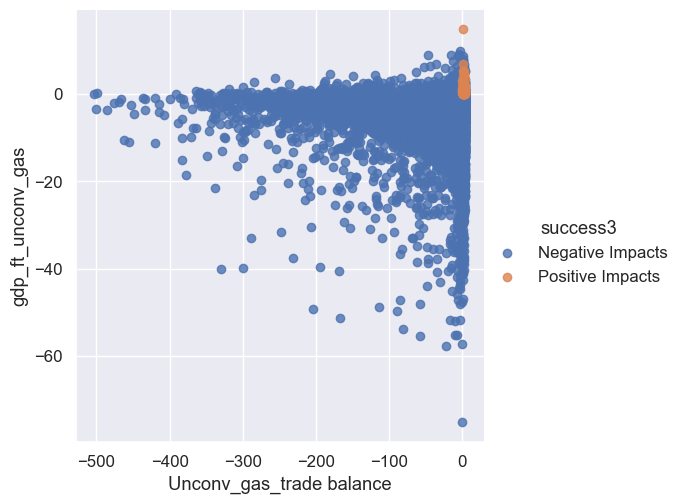

In [15]:
#do trade and fiscal impact on the axis - then color by npv

# data["gdp_npv_unconv_gas"]
plot = sns.lmplot(x="Unconv_gas_trade balance", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='success3', legend=True)
plt.show()

# 

In [16]:
print(pd.Series.corr(data['scenario'],data['wells_total']))

-0.013465341421578288


In [17]:
# pd.crosstab(data['scenario'],data['success3'])

from scipy import stats
crosstab = pd.crosstab(data['success3'],data['scenario'])
stats.chi2_contingency(crosstab)

(24.458667945464374,
 4.8850356593470596e-06,
 2,
 array([[9.3781347e+03, 3.9120840e+02, 1.0965690e+02],
        [1.1486530e+02, 4.7916000e+00, 1.3431000e+00]]))

In [18]:
# pd.crosstab(data['scenario'],data['success_ft'])

crosstab = pd.crosstab(data['scenario'],data['success_ft'])
stats.chi2_contingency(crosstab)

(3.14978091533568,
 0.20703023001328938,
 2,
 array([[8.9632906e+03, 5.2970940e+02],
        [3.7390320e+02, 2.2096800e+01],
        [1.0480620e+02, 6.1938000e+00]]))

In [19]:
pd.crosstab(data['scenario'],data['success_ft'])


success_ft,0.0,1.0
scenario,,
0,8960,533
1,380,16
2,102,9


In [20]:
pd.crosstab(data['scenario'],data['success_tb'])

success_tb,0.0,1.0
scenario,,
0,8194,1299
1,367,29
2,68,43


In [21]:
crosstab = pd.crosstab(data['scenario'],data['success_tb'])
stats.chi2_contingency(crosstab)

(72.43590986662099,
 1.8652713800372422e-16,
 2,
 array([[8191.5097, 1301.4903],
        [ 341.7084,   54.2916],
        [  95.7819,   15.2181]]))

In [22]:
crosstab = pd.crosstab(data['scenario'],data.loc[data['wells_total']<=10000,'wells_total'])
stats.chi2_contingency(crosstab)

(845.3201148774829,
 0.239128380891251,
 817,
 array([[0.95459579, 0.95459579, 0.95459579, ..., 0.95459579, 0.95459579,
         0.95459579],
        [0.04540421, 0.04540421, 0.04540421, ..., 0.04540421, 0.04540421,
         0.04540421]]))

C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:404: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


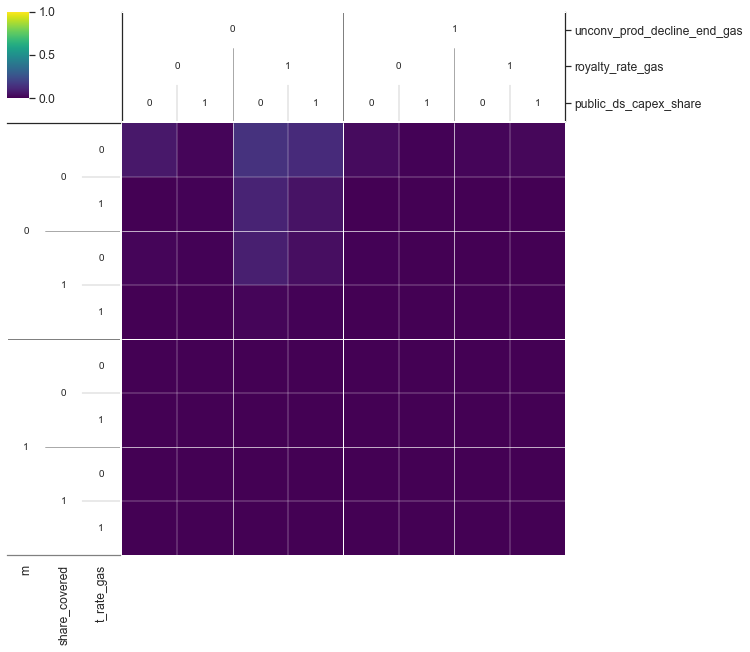

In [23]:
%matplotlib inline

x = experiments
y = (data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0)&(data['Unconv_gas_trade balance'] >0)

dimensional_stacking.create_pivot_plot(x,y, 3, nbins=2, categories = True, labels = True)
plt.show()

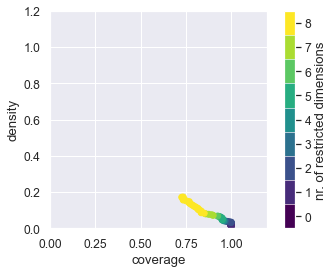

In [24]:
y = (data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0)&(data['Unconv_gas_trade balance'] >0)
# y = (data['gdp_npv_unconv_gas'] <0)|(data['gdp_ft_unconv_gas'] <0)|(data['Unconv_gas_trade balance'] <0)
prim_alg = prim.Prim(x, y, threshold=0.05)
box1 = prim_alg.find_box() 

%matplotlib inline
box1.show_tradeoff()
plt.show()

coverage    0.818182
density     0.103448
id                45
mass          0.0957
mean        0.103448
res_dim            8
Name: 45, dtype: object

                                  box 45                \
                                     min           max   
m                            2000.682260  30728.423463   
unconv_prod_decline_end_gas     0.000007      0.129081   
t_rate_gas                     -0.099984      0.071984   
gas_export_dem_end              0.000072      0.951359   
royalty_rate_gas                0.055684      0.299972   
gas_ex_cap_end               2192.531633   4532.094714   
gas_demand_decline_speed        6.500000     30.000000   
a_el_ind                        0.005502      0.099998   

                                                                        
                                                             qp values  
m                                       [-1.0, 3.1969348959964173e-24]  
unconv_prod_decline_end_gas              [-1.0, 9

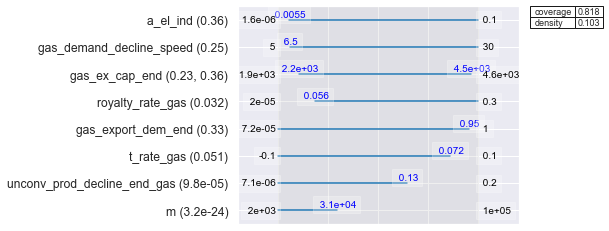

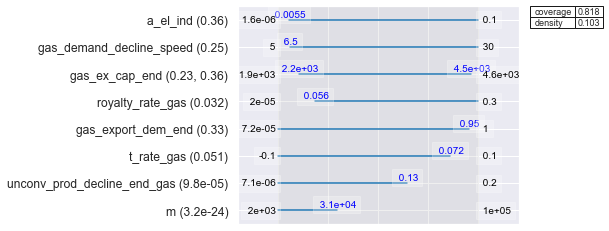

In [25]:
# %matplotlib notebook
box1.inspect(i=45, style='table')
box1.inspect(i=45, style='graph')

count     10000
unique        2
top        True
freq       7148
Name: Unconv_gas_trade balance, dtype: object

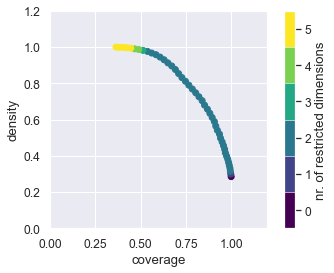

In [27]:
y = (data['gdp_npv_unconv_gas'] >0)&(data['Unconv_gas_trade balance'] >0)
prim_alg = prim.Prim(x, y, threshold=0.15)
box1 = prim_alg.find_box() 

box1.show_tradeoff()
plt.show()

coverage     0.56101
density     0.967352
id                35
mass          0.1654
mean        0.967352
res_dim            2
Name: 35, dtype: object

                               box 35            \
                                  min       max   
unconv_prod_decline_end_gas  0.000007  0.065083   
t_rate_gas                  -0.099984  0.003463   

                                                              
                                                   qp values  
unconv_prod_decline_end_gas                      [-1.0, 0.0]  
t_rate_gas                   [-1.0, 1.1951923385998269e-226]  



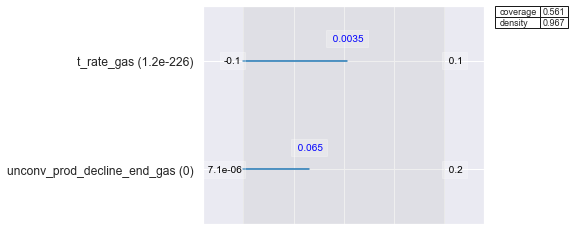

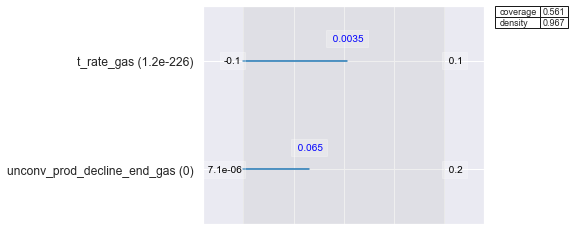

In [28]:
%matplotlib inline
box1.inspect(i=35, style='table')
box1.inspect(i=35, style='graph')

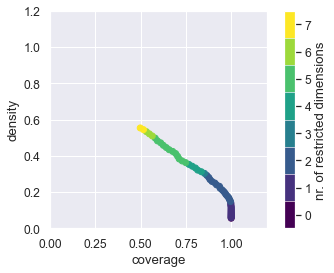

In [29]:
y = (data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0)
prim_alg = prim.Prim(x, y, threshold=0.15)
box1 = prim_alg.find_box() 

box1.show_tradeoff()
plt.show()

coverage    0.704301
density     0.397773
id                45
mass          0.0988
mean        0.397773
res_dim            5
Name: 45, dtype: object

                            box 45                \
                               min           max   
m                      2000.682260  19817.546726   
share_covered             0.000022      0.662732   
prod_subsidy_p_ratio      1.000093      1.949388   
public_ds_capex_share     0.000044      0.961098   
royalty_rate_gas          0.109592      0.299972   

                                                        
                                             qp values  
m                      [-1.0, 4.4602326168529805e-155]  
share_covered              [-1.0, 0.22347786444636952]  
prod_subsidy_p_ratio        [-1.0, 0.2515156260251418]  
public_ds_capex_share       [-1.0, 0.2638180464571225]  
royalty_rate_gas        [1.6299856565774125e-15, -1.0]  



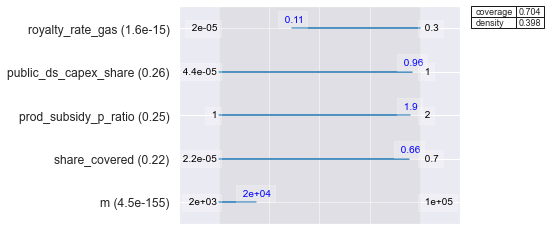

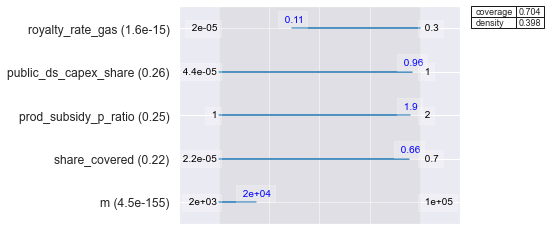

In [30]:
%matplotlib inline
box1.inspect(i=45, style='table')
box1.inspect(i=45, style='graph')

In [31]:
#highly supported - high subsidy rate high subsidy shar
data.loc[(data['prod_subsidy_p_ratio'] >data["prod_subsidy_p_ratio"].quantile(.5))&(data['public_ds_capex_share'] >data["public_ds_capex_share"].quantile(.5))&(data['share_covered'] >data["share_covered"].quantile(.5)), 'support'] =0
data.loc[(data['prod_subsidy_p_ratio'] <=data["prod_subsidy_p_ratio"].quantile(.5))&(data['public_ds_capex_share'] <=data["public_ds_capex_share"].quantile(.5))&(data['share_covered'] <= data["share_covered"].quantile(.5)), 'support'] =1

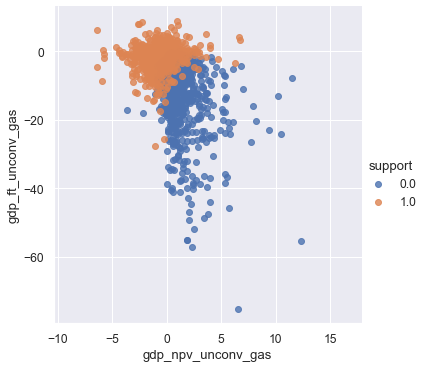

In [32]:
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='support', legend=True)
plt.show()

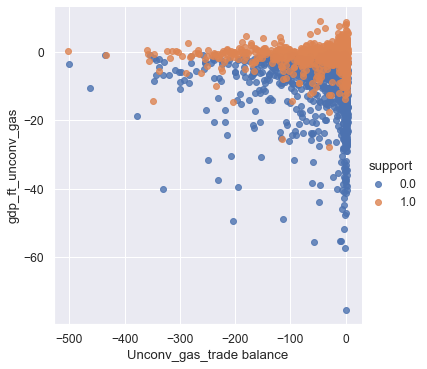

In [33]:
plot = sns.lmplot(x="Unconv_gas_trade balance", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='support', legend=True)
plt.show()

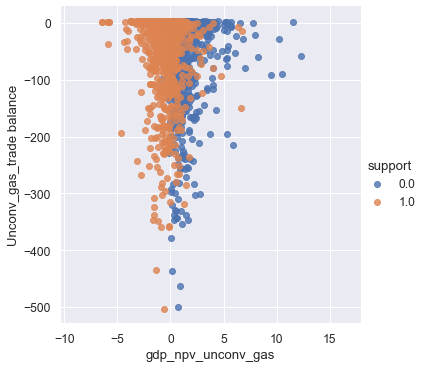

In [81]:
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="Unconv_gas_trade balance", data=data, fit_reg=False, hue='support', legend=True)
plt.show()

In [35]:
# diverging_colors = sns.color_palette("RdBu", 3)

# plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue="Unconv_gas_trade balance", legend=True)
# plt.show()

In [36]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# z =data['gdp_npv_unconv_gas']
# y =data['gdp_ft_unconv_gas']
# x =data['Unconv_gas_trade balance']

# c = (data['success3']>0)
# ax.scatter(x, y, z, c=c, marker='o')

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# plt.show()

C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:404: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


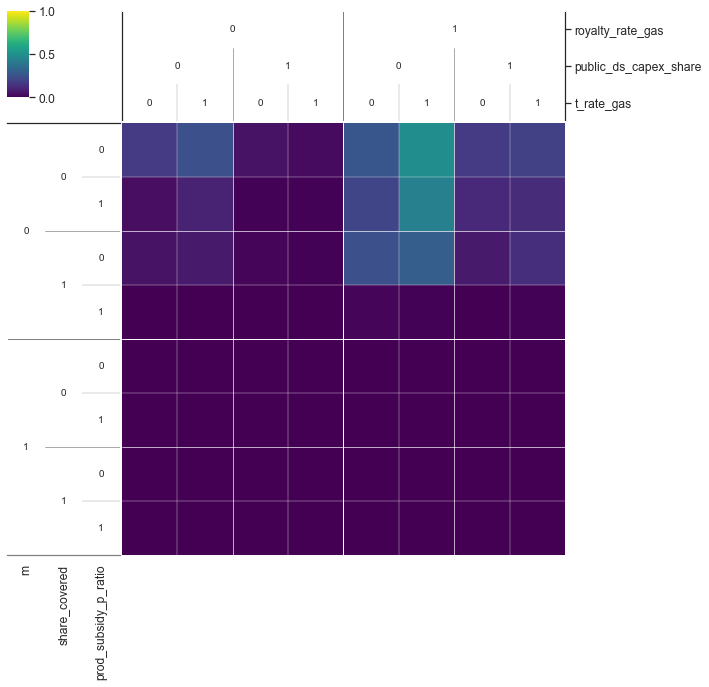

In [37]:
%matplotlib inline
x = experiments
y = (data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0)

dimensional_stacking.create_pivot_plot(x,y, 3, nbins=2)
plt.show()

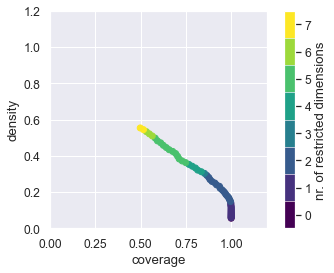

In [97]:
y = (data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0)
prim_alg = prim.Prim(x, y, threshold=0.15)
box1 = prim_alg.find_box() 

box1.show_tradeoff()
plt.show()

coverage    0.657706
density     0.433806
id                48
mass          0.0846
mean        0.433806
res_dim            5
Name: 48, dtype: object

                            box 48                \
                               min           max   
m                      2000.682260  18091.052623   
prod_subsidy_p_ratio      1.000093      1.903865   
share_covered             0.000022      0.662732   
public_ds_capex_share     0.000044      0.961098   
royalty_rate_gas          0.109592      0.299972   

                                                        
                                             qp values  
m                      [-1.0, 2.2107856590047097e-156]  
prod_subsidy_p_ratio        [-1.0, 0.0961363378633522]  
share_covered              [-1.0, 0.25312695559060466]  
public_ds_capex_share      [-1.0, 0.25742356631964775]  
royalty_rate_gas         [4.432422146136495e-15, -1.0]  



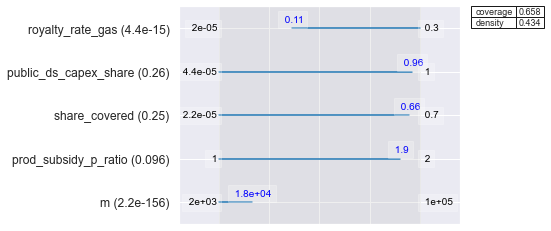

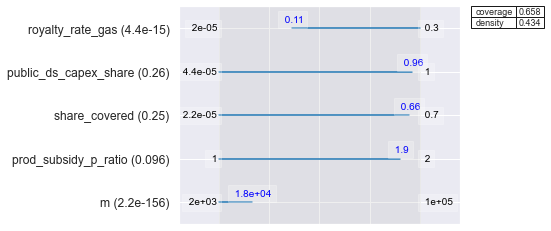

In [98]:
%matplotlib inline
box1.inspect(i=48, style='table')
box1.inspect(i=48, style='graph')

C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:404: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


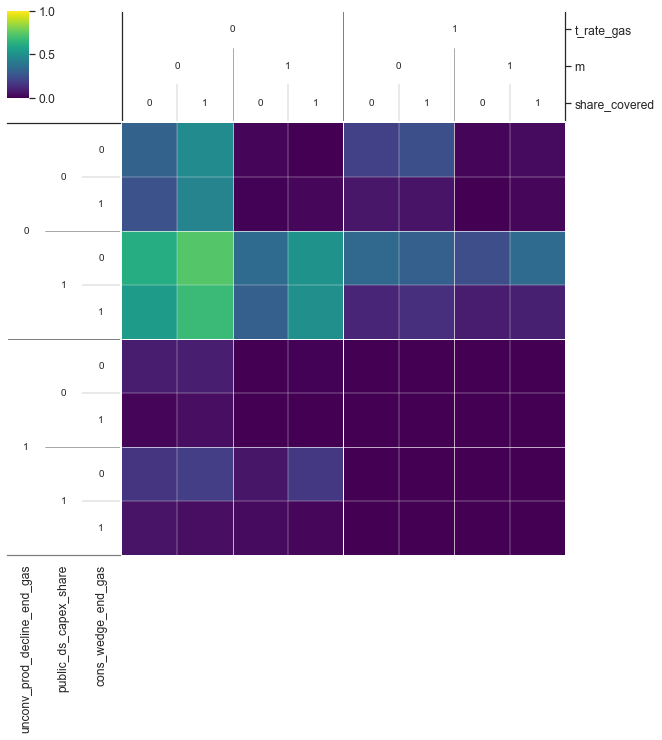

In [135]:
%matplotlib inline
x = experiments
y = (data['Unconv_gas_trade balance'] >0)&(data['gdp_npv_unconv_gas'] >0)

dimensional_stacking.create_pivot_plot(x,y, 3, nbins=2)
plt.show()

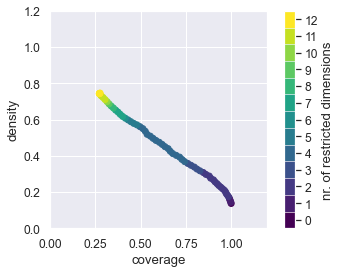

In [127]:
y = (data['Unconv_gas_trade balance'] >0)&(data['gdp_npv_unconv_gas'] >0)
prim_alg = prim.Prim(x, y, threshold=0.15)
box2 = prim_alg.find_box() 

box2.show_tradeoff()
plt.show()

coverage    0.462436
density     0.578995
id                43
mass          0.1095
mean        0.578995
res_dim            5
Name: 43, dtype: object

                                  box 43                \
                                     min           max   
unconv_prod_decline_end_gas     0.000007      0.068539   
m                            2000.682260  70628.698929   
public_ds_capex_share           0.259999      0.999987   
gas_ex_cap_end               2062.493425   4630.751692   
t_rate_gas                     -0.092385      0.040006   

                                                                            
                                                                 qp values  
unconv_prod_decline_end_gas                [-1.0, 1.1992143961777203e-112]  
m                                           [-1.0, 2.0096390977109553e-09]  
public_ds_capex_share                       [2.4833122971741183e-09, -1.0]  
gas_ex_cap_end                                  [0.250553

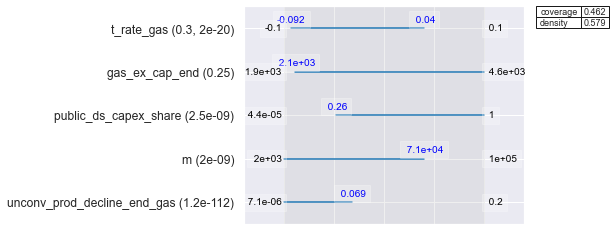

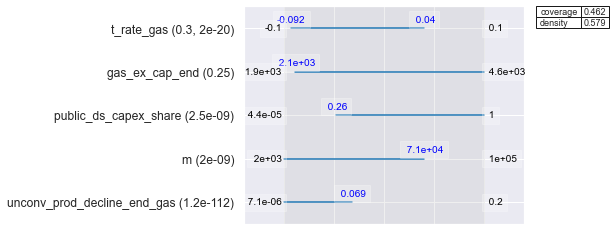

In [133]:
%matplotlib inline
box2.inspect(i=43, style='table')
box2.inspect(i=43, style='graph')

C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:404: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


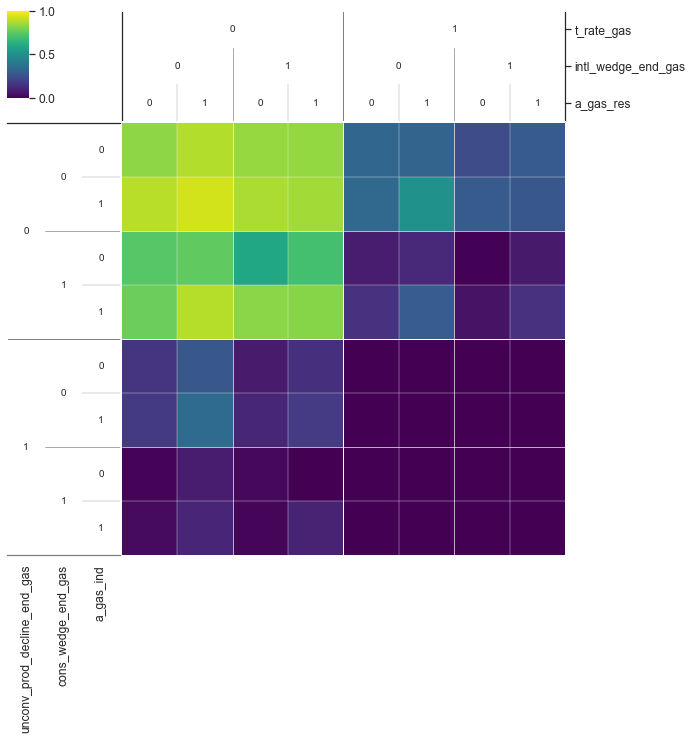

In [134]:
%matplotlib inline
x = experiments
y = (data['Unconv_gas_trade balance'] >0)

dimensional_stacking.create_pivot_plot(x,y, 3, nbins=2)
plt.show()

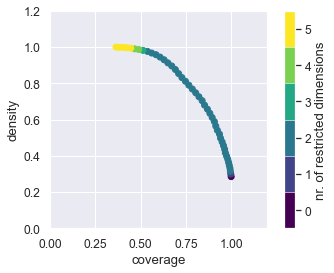

In [136]:
y = (data['Unconv_gas_trade balance'] >0)
prim_alg = prim.Prim(x, y, threshold=0.15)
box6 = prim_alg.find_box() 

box6.show_tradeoff()
plt.show()

coverage    0.467391
density     0.990342
id                39
mass          0.1346
mean        0.990342
res_dim            4
Name: 39, dtype: object

                               box 39            \
                                  min       max   
unconv_prod_decline_end_gas  0.000007  0.061820   
t_rate_gas                  -0.099984  0.003463   
cons_wedge_end_gas           0.100900  9.544802   
a_gas_res                    0.009393  0.099997   

                                                              
                                                   qp values  
unconv_prod_decline_end_gas                      [-1.0, 0.0]  
t_rate_gas                   [-1.0, 2.2213256660882374e-205]  
cons_wedge_end_gas               [-1.0, 0.09788496130652309]  
a_gas_res                       [0.005275559623664405, -1.0]  



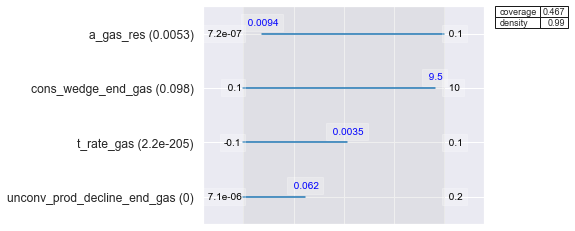

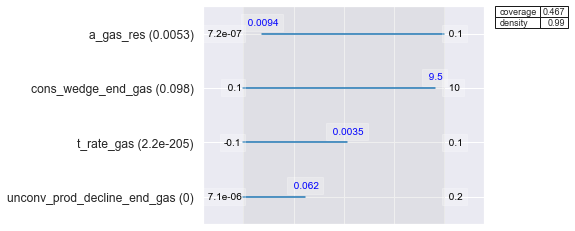

In [143]:
%matplotlib inline
box6.inspect(i=39, style='table')
box6.inspect(i=39, style='graph')

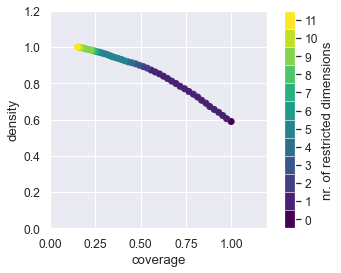

In [107]:
y = (data['gdp_npv_unconv_gas'] >0)
prim_alg = prim.Prim(x, y, threshold=0.15)
box4 = prim_alg.find_box() 

box4.show_tradeoff()
plt.show()

coverage    0.536817
density     0.884046
id                20
mass          0.3579
mean        0.884046
res_dim            2
Name: 20, dtype: object

                         box 20                                        
                            min       max                     qp values
public_ds_capex_share  0.623171  0.999987      [3.459338779e-313, -1.0]
t_rate_gas            -0.089821  0.099988  [0.028348676758562306, -1.0]



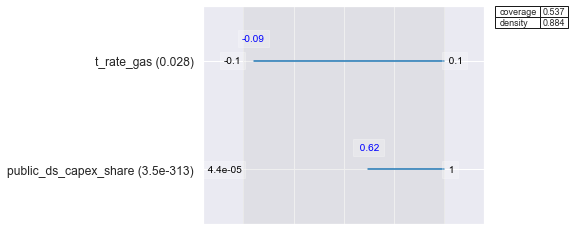

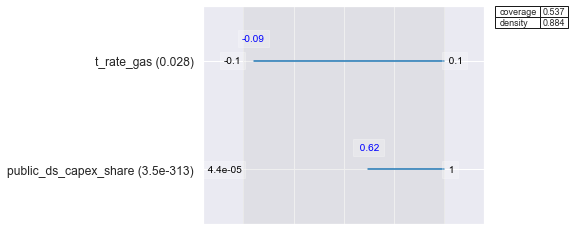

In [132]:
%matplotlib inline
box4.inspect(i=20, style='table')
box4.inspect(i=20, style='graph')

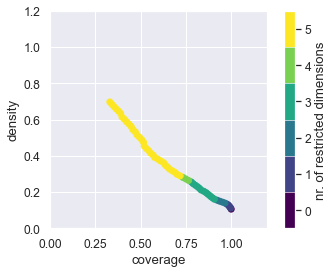

In [108]:
y = (data['gdp_ft_unconv_gas'] >0)
prim_alg = prim.Prim(x, y, threshold=0.15)
box5 = prim_alg.find_box() 

box5.show_tradeoff()
plt.show()

coverage    0.595845
density     0.381499
id                35
mass          0.1654
mean        0.381499
res_dim            5
Name: 35, dtype: object

                            box 35                \
                               min           max   
public_ds_capex_share     0.000044      0.435372   
share_covered             0.000022      0.548663   
m                      2000.682260  85802.392978   
prod_subsidy_p_ratio      1.000093      1.903599   
royalty_rate_gas          0.111281      0.299972   

                                                       
                                            qp values  
public_ds_capex_share   [-1.0, 5.902977793939923e-56]  
share_covered          [-1.0, 1.7786303851998958e-06]  
m                       [-1.0, 0.0008406127280697647]  
prod_subsidy_p_ratio        [-1.0, 0.062650702613065]  
royalty_rate_gas       [1.8528876834597692e-24, -1.0]  



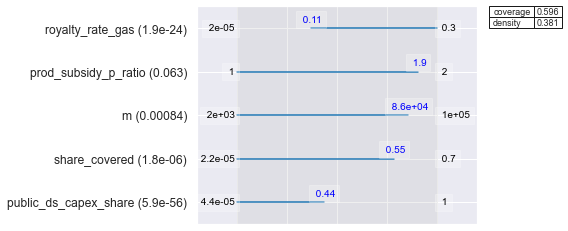

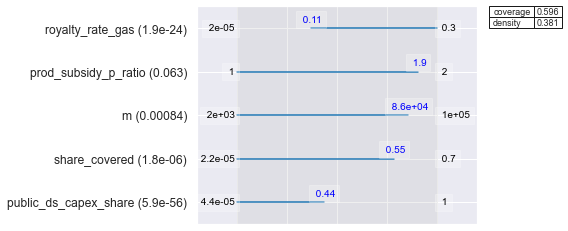

In [115]:
%matplotlib inline
box5.inspect(i=35, style='table')
box5.inspect(i=35, style='graph')

In [109]:
from scipy import stats
crosstab = pd.crosstab(data['success3'],data['support'])
print(crosstab)
stats.chi2_contingency(crosstab)

support            0.0   1.0
success3                    
Negative Impacts  1250  1227
Positive Impacts     0    28


(26.221236370912912,
 3.044559375599147e-07,
 1,
 array([[1236.02794411, 1240.97205589],
        [  13.97205589,   14.02794411]]))

In [110]:
crosstab = pd.crosstab(data['success_tb'],data['support'])
print(crosstab)
stats.chi2_contingency(crosstab)

support     0.0   1.0
success_tb           
0.0         940  1194
1.0         310    61


(195.7646209977662,
 1.7544250561439469e-44,
 1,
 array([[1064.87025948, 1069.12974052],
        [ 185.12974052,  185.87025948]]))

In [111]:
crosstab = pd.crosstab(data['success_ft'],data['support'])
print(crosstab)
stats.chi2_contingency(crosstab)

support      0.0   1.0
success_ft            
0.0         1249  1067
1.0            1   188


(197.18393409706843,
 8.597690641458875e-45,
 1,
 array([[1155.68862275, 1160.31137725],
        [  94.31137725,   94.68862275]]))

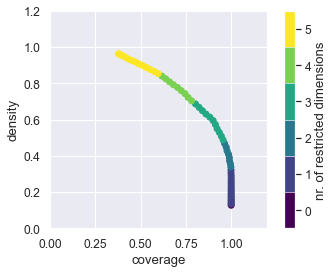

In [112]:
x = experiments
y = (data['Unconv_gas_trade balance'] <-100)
prim_alg = prim.Prim(x, y, threshold=0.15)
box6 = prim_alg.find_box() 

box6.show_tradeoff()
plt.show()

coverage         1.0
density     0.275497
id                15
mass          0.4628
mean        0.275497
res_dim            1
Name: 15, dtype: object

              box 15                                           
                 min       max                        qp values
t_rate_gas  0.007435  0.099988  [2.3799336132513767e-158, -1.0]



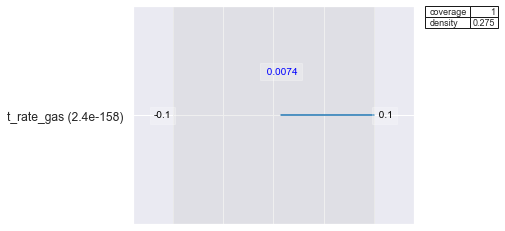

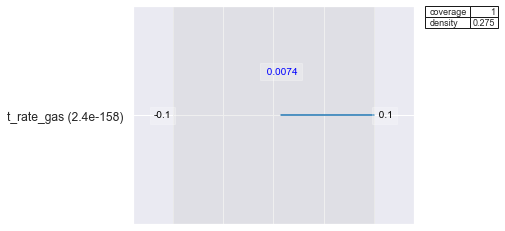

In [113]:
%matplotlib inline
box6.inspect(i=15, style='table')
box6.inspect(i=15, style='graph')

# subset

In [48]:
param_names =['rcp', 'T_bond_rate','arg_sov_risk','opp_cost_own_finance','share_own_capital','opp_cost_debt',
              'pes_oil','pes_gas','t_rate_gas','t_rate_oil','t_rate_e','us_capex_gas','us_capex_oil',
              'm','oil_opex','gas_opex','share_covered','prod_subsidy_p_ratio','royalty_rate_gas',
              'duty_rate_gas','royalty_rate_oil','duty_rate_oil','price_threshold_gas','price_threshold_oil',
              'price_floor_gas','price_floor_oil','conv_start_gr_gas','conv_start_gr_oil',
              'conv_prod_decline_end_gas','conv_prod_decline_end_oil','unconv_prod_decline_end_gas',
              'unconv_prod_decline_end_oil','cons_wedge_end_gas','cons_wedge_end_oil','intl_wedge_end_gas',
              'intl_wedge_end_oil','a_gas_trans','a_gas_res','a_gas_ind','a_oil_trans','a_oil_res',
              'a_oil_ind','a_el_trans','a_el_res','a_el_ind','well_life','gas_ex_cap_end',
              'gas_ex_cap_increase','oil_ex_cap_end','oil_ex_cap_increase',
              'gas_export_dem_end','oil_export_dem_end',
              'gas_demand_decline_speed','oil_demand_decline_speed','public_ds_capex_share']


In [49]:
d = data[((data['m']<30000)&
#     (data['unconv_prod_decline_end_gas']<.05)]
    (data['t_rate_gas']<.03))]

In [49]:
data['subset'] =0
data.loc[(data['m']<30000)&  
         (data['t_rate_gas']<.03),'subset'] = 1
#          (data['unconv_prod_decline_end_gas']<.05),'subset'] = 1

In [50]:
d.describe()

,npv_gdp,npv_unsub_gdp,total_ft_gdp,wells_total,unconv_share,gas_share,gdp_npv_conv_gas,gdp_npv_conv_oil,gdp_npv_unconv_gas,gdp_npv_unconv_oil,...,Conv_oil_starts,Unconv_oil_starts,Conv_gas_discount_factor,Unconv_gas_discount_factor,Conv_oil_discount_factor,Unconv_oil_discount_factor,success_ft,success_tb,three_level,support
count,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,...,1.839000e+03,1.839000e+03,1.839000e+03,1.839000e+03,1.839000e+03,1.839000e+03,1839.000000,1839.000000,1839.000000,428.000000
mean,5.830314,6.964091,0.731941,21453.404568,0.859855,0.342440,0.304643,2.685528,0.613583,2.226560,...,8.740094e-08,1.249717e-06,1.280656e-09,1.280656e-09,1.280656e-09,1.280656e-09,0.164763,0.319739,0.377379,0.528037
std,2.661566,2.981994,1.060283,15018.014837,0.084579,0.112796,0.169663,0.834972,0.751275,1.735963,...,8.219522e-08,1.375547e-06,4.402347e-10,4.402347e-10,4.402347e-10,4.402347e-10,0.371068,0.466502,0.591975,0.499798
min,0.373649,0.355609,-8.794882,4398.333333,0.497998,0.007788,-0.282202,0.614749,-4.444927,-1.151928,...,0.000000e+00,1.224308e-07,6.801223e-10,6.801223e-10,6.801223e-10,6.801223e-10,0.000000,0.000000,0.000000,0.000000
25%,4.076378,5.066337,0.097489,12285.833333,0.820608,0.308885,0.192439,2.107933,0.210628,1.174334,...,2.299461e-08,3.158652e-07,9.716055e-10,9.716055e-10,9.716055e-10,9.716055e-10,0.000000,0.000000,0.000000,0.000000
50%,5.231599,6.267015,0.665097,19408.333333,0.885015,0.327327,0.299542,2.557093,0.502127,1.791485,...,5.997244e-08,9.353214e-07,1.169260e-09,1.169260e-09,1.169260e-09,1.169260e-09,0.000000,0.000000,0.000000,1.000000
75%,6.918820,8.077845,1.248881,27146.333333,0.922286,0.351957,0.395665,3.082494,0.851334,2.687155,...,1.291893e-07,1.810127e-06,1.458598e-09,1.458598e-09,1.458598e-09,1.458598e-09,0.000000,1.000000,1.000000,1.000000
max,28.527125,31.807334,7.442248,333167.333333,0.994453,0.994259,1.656163,7.350363,6.872613,21.019559,...,3.360632e-07,2.109430e-05,3.735620e-09,3.735620e-09,3.735620e-09,3.735620e-09,1.000000,1.000000,2.000000,1.000000


In [50]:
x = d[param_names]

In [52]:
# crosstab = pd.crosstab(d['three_level'],d['support'])
# stats.chi2_contingency(crosstab)

In [53]:
# plot = sns.lmplot(x="gdp_ft_unconv_gas", y="gdp_npv_unconv_gas", data=d, fit_reg=False, hue='success3', legend=True)
# plt.show()

In [54]:
# #data_cut.describe()
# pd.crosstab(d['subset'],d['three_level'])

C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy

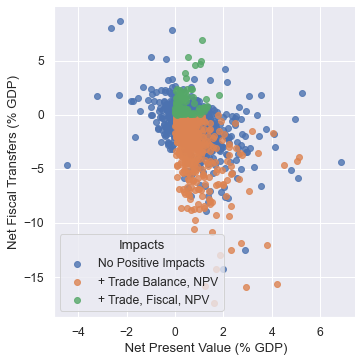

In [51]:
#graph for executive Summary

d.loc[(d['gdp_npv_unconv_gas'] <0)|(d['gdp_ft_unconv_gas'] <0)|(d['Unconv_gas_trade balance'] <0), 'three_level'] = 0
d.loc[(d['Unconv_gas_trade balance'] >0)&(d['gdp_npv_unconv_gas'] >0), 'three_level'] =1
d.loc[(d['gdp_npv_unconv_gas'] >0)&(d['gdp_ft_unconv_gas'] >0)&(d['Unconv_gas_trade balance'] >0), 'three_level'] =2

sns.set(font_scale = 1.1)
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=d, fit_reg=False, hue='three_level', legend=True, legend_out = False)
plot.set_titles("Impacts of Vaca Muerta")  # use this argument literally
plot.set_axis_labels(x_var=" Net Present Value (% GDP)", y_var="Net Fiscal Transfers (% GDP)")
# plt.legend(title='Impacts', loc='upper left', labels=['No Positive Impacts', '+ Trade Balance and NPV Impacts','+ Trade Balance, Fiscal, NPV Impacts'])
new_title = 'Impacts'
plot._legend.set_title(new_title)
# replace labels
new_labels = ['No Positive Impacts', '+ Trade Balance, NPV','+ Trade, Fiscal, NPV']
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy

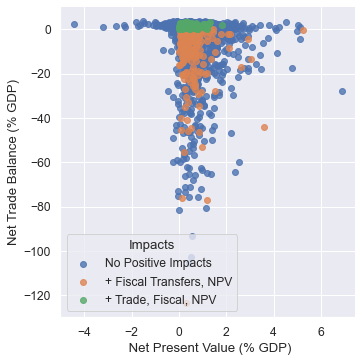

In [52]:
sns.set(font_scale = 1.1)
d.loc[(d['gdp_npv_unconv_gas'] <0)|(d['gdp_ft_unconv_gas'] <0)|(d['Unconv_gas_trade balance'] <0), 'three_level'] = 0
d.loc[(d['gdp_ft_unconv_gas'] >0)&(d['gdp_npv_unconv_gas'] >0), 'three_level'] =1
d.loc[(d['gdp_npv_unconv_gas'] >0)&(d['gdp_ft_unconv_gas'] >0)&(d['Unconv_gas_trade balance'] >0), 'three_level'] =2

plot = sns.lmplot(x="gdp_npv_unconv_gas", y="Unconv_gas_trade balance", data=d, fit_reg=False, hue='three_level', legend=True, legend_out = False)
plot.set_titles("Impacts of Vaca Muerta")  # use this argument literally
plot.set_axis_labels(x_var=" Net Present Value (% GDP)", y_var="Net Trade Balance (% GDP)")
# plt.legend(title='Impacts', loc='upper left', labels=['No Positive Impacts', '+ Trade Balance and NPV Impacts','+ Trade Balance, Fiscal, NPV Impacts'])
new_title = 'Impacts'
plot._legend.set_title(new_title)
# replace labels
new_labels = ['No Positive Impacts', '+ Fiscal Transfers, NPV','+ Trade, Fiscal, NPV']
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [53]:
# summary = data.loc[(data['subset'] ==1)&(data['Unconv_gas_trade balance'] <-50)]
# # summary.to_csv(outdir+"summary_neg_tb.csv")

In [54]:
pd.crosstab(d['scenario'],d['success_tb'])
#1839 #588 #32%

success_tb,0.0,1.0
scenario,,
0,1184,560
1,53,8
2,14,20


In [59]:
pd.crosstab(d['scenario'],d['success_ft'])
#1839 #303 #16%

success_ft,0.0,1.0
scenario,,
0,1457,287
1,53,8
2,26,8


In [82]:
d.loc[(d['wells_total']>10000), 'wells_high'] = 1
d.loc[(d['wells_total']<=10000), 'wells_high'] = 0

data.loc[(data['wells_total']>10000), 'wells_high1'] = 1
data.loc[(data['wells_total']<=10000), 'wells_high1'] = 0


d['wells_high'].describe()
pd.crosstab(d['scenario'],d['wells_high'])

C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


wells_high,0.0,1.0
scenario,,
0,242,1502
1,0,61
2,13,21


In [69]:
pd.crosstab(d['scenario'],d['success3'])
#106 #5.7%

success3,Negative Impacts,Positive Impacts
scenario,,
0,1647,97
1,58,3
2,28,6


In [70]:
pd.crosstab(d['success3'],d['wells_high'])

wells_high,0.0,1.0
success3,,
Negative Impacts,1415,318
Positive Impacts,101,5


In [86]:
crosstab = pd.crosstab(d['success3'],d['wells_high'])
print(crosstab)
stats.chi2_contingency(crosstab)

wells_high        0.0   1.0
success3                   
Negative Impacts  228  1505
Positive Impacts   27    79


(11.674586168038791,
 0.0006335963230539965,
 1,
 array([[ 240.30179445, 1492.69820555],
        [  14.69820555,   91.30179445]]))

In [84]:
crosstab = pd.crosstab(data['success3'],data['wells_high1'])
print(crosstab)
stats.chi2_contingency(crosstab)

wells_high1       0.0   1.0
success3                   
Negative Impacts  876  9003
Positive Impacts   27    94


(24.700133938702663,
 6.697951941190335e-07,
 1,
 array([[ 892.0737, 8986.9263],
        [  10.9263,  110.0737]]))

In [61]:
# pd.crosstab(data['scenario'],data['success3'])

crosstab = pd.crosstab(d['success3'],d['scenario'])
stats.chi2_contingency(crosstab)

(9.0502998193648,
 0.010833090329573806,
 2,
 array([[1643.47580207,   57.48395867,   32.04023926],
        [ 100.52419793,    3.51604133,    1.95976074]]))

In [62]:
pd.crosstab(d['success3'],d['support'])

support,0.0,1.0
success3,,
Negative Impacts,202,202
Positive Impacts,0,24


In [76]:
crosstab = pd.crosstab(d['success3'],d['support'])
stats.chi2_contingency(crosstab)

(20.763636272284025,
 5.196026581217253e-06,
 1,
 array([[190.6728972, 213.3271028],
        [ 11.3271028,  12.6728972]]))

In [ ]:
outcomes = pd.read_csv(indir+"vm_outcomes_2.csv")
experiments = pd.read_csv(indir+"vm_experiments_2.csv")
tradebal= pd.read_csv(indir+"fiscal ts outcomes_2.csv",index_col = False,names = colnames, skiprows = 1 )
physbal = pd.read_csv(indir+"physical ts outcomes_2.csv" )

In [73]:
y =d['gdp_ft_unconv_gas'] >0
prim_alg = prim.Prim(x, y, threshold=0.1)
box1 = prim_alg.find_box() 

box1.show_tradeoff()
plt.show()

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([   1,    2,    3,    4,    5,\n            ...\n            1833, 1834, 1836, 1837, 1838],\n           dtype='int64', name='run', length=1490). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [ ]:
%matplotlib inline
box1.inspect(i=30, style='table')
box1.inspect(i=30, style='graph')

In [ ]:
%matplotlib inline

y = (d['gdp_ft_unconv_gas'] >0)
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=2)
plt.show()